README:

Small network is a model looking at individual cell activity. All connections are included along with synaptic weights being 1 to simulate what activity would look like on the cellular level. 

In [1]:
import multiprocessing
from functools import reduce
import operator
import random
import h5py

import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from GrC import GrC
from Golgi import Golgi
from utils import export_data

# Random generator
local_random = np.random.default_rng(123)

# np.random.seed(42)

In [2]:
# Instantiation of the cell templates

golgi_cells = [[Golgi(i, morpho) for i in range(count)] for morpho, count in (
    (1, 1),  # morpho 1
    (2, 1),  # morpho 2
 )]

golgi_cells = reduce(operator.concat, golgi_cells)
random.shuffle(golgi_cells)
golgi_cells = golgi_cells[:2]

grc_cells = [[GrC(i, subtype) for i in range(count)] for subtype, count in (
    ("regular", 2), # 20%
    ("mild", 3), # 30%
    ("adapting", 4), # 40%
    ("accelerate", 1), # 10%
)]

grc_cells = reduce(operator.concat, grc_cells)
random.shuffle(grc_cells)
grc_cells = grc_cells[:2]

ascending_axons = sum((grc_cell.HD_aa for grc_cell in grc_cells), [])
parallel_fibers = sum((grc_cell.HD_pf for grc_cell in grc_cells), [])



5394 lines read

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read

103 lines read


In [3]:
# Fixed time step only
time_step = h.CVode()
time_step.active(0)  # 0 fixed step, 1 variable time step

DO_IMPEDANCE_MEASUREMENT = False

if DO_IMPEDANCE_MEASUREMENT:
    h.load_file("stdrun.hoc")
else:
    # Activate the multisplit to use half of cores available (with a max of 8)
    cpu = multiprocessing.cpu_count() // 2
    h.load_file("parcom.hoc")
    p = h.ParallelComputeTool()
    p.change_nthread(min(8, cpu), 1)
    p.multisplit(1)

# simulation parameters
 
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.v_init = -65  # initial membrane potential (mV)
h.tstop = 3000 # duration of simulation (ms)

# time vectors
t = h.Vector()
t.record(h._ref_t)

Vector[32153]

In [4]:
start_time = 500 # when current injection starts
stop_time = 2500 # duration
freq = 20 # Hz
amp = 0.01 # nA

isi = 1000/freq # inter-spike interval
spike_times = [] # array for spike times
for spike in range(5):
    spike_times.append(start_time + spike * isi) # for loop will create an array of spike times equal to the frequency and time frame hard coded above

stims_array = [] # list for iClamp
stim_rec_array = [] # list for current from iCLamp
vs_array = [] # list for play method

golgi_input_resis_array = [] # list for golgi cell input resistance
grc_input_resis_array = [] # list for grc cell input resistance

golgi_halfwidth_array = [] # list for golgi halfwidth
grc_halfwidth_array = [] # list for grc halfwidth

golgi_ncs_array = [] # list for golgi netcons
grc_ncs_array = [] # list for grc netcons

golgi_fr_array = [] # list for # of times a golgi cell spiked to determine firing rate
grc_fr_array = [] # list for # of times a grc cell spiked to determine firing rate

max_golgi_v_array = [] # list for golgi cell max voltage
min_golgi_v_array = [] # list for golgi cell min voltage
max_grc_v_array = [] # list for grc cell max voltage
min_grc_v_array = [] # list for grc cell min voltage

# dict of stim data to be sent for syn stims
stim_data_pf = {'delay': start_time, 'duration': stop_time, 'amp': amp, 'spike_times': spike_times}
stim_data_mf = {'delay': start_time, 'duration': stop_time, 'amp': amp, 'spike_times': spike_times}
stim_data_aa = {'delay': start_time, 'duration': stop_time, 'amp': amp, 'spike_times': spike_times}


In [5]:
def create_syn_stim(cell, synapses, stim_data_mf):

    """
    Generates single pulse current to soma of cell. 

    delay: time after amp is injected
    dur: duration of amp injection
    amp: amount of amp injected
    """

    # ask if it makes sense to have iclamp to soma instead of dendrite
    stim = h.IClamp(cell.soma[0](0.5)) # iclamp to soma of cell
    stim.delay = stim_data_mf['delay']
    stim.dur = stim_data_mf['duration']
    stim.amp = stim_data_mf['amp']
    stims_array.append(stim)
    
    # recording of current from iclamp
    stim_i_rec = h.Vector()
    stim_rec_array.append(stim_i_rec.record(stim._ref_i))

    # saving mossy fiber stim synapse to netcon lists
    if type(synapses) == type(grc_cells):
        grc_ncs_array.extend(h.NetCon(stim, syn.input, 0, 0.1, 1) for syn in synapses)
        
    else:
        golgi_ncs_array.extend(h.NetCon(stim, syn.input, 0, 0.1, 1) for syn in synapses)   

    # play method for sending stim to cell using array of spike times
    vs = h.Vector() 
    vs_array.append(vs.play(stim.amp, h.Vector(stim_data_mf['spike_times'])))    


In [6]:
for j, grc_cell in enumerate(grc_cells):
    
    # number of AMPA syn, NMDA syn, GABA syn, dend number from indices
    # grc cells connect to 4 different glomeri and synapse
    grc_cell.createsyn(4, 4, 3, [0, 1, 2, 3]) # 4 dendritic comparts (0-3)
    
    # mossy fiber connection
    create_syn_stim(grc_cell, grc_cell.MF_GrC_AMPA + grc_cell.MF_GrC_NMDA_B, stim_data_mf)

    # golgi cell connection 
    for i, golgi_cell in enumerate(golgi_cells):
        grc = grc_cell.dend[:]
        sections = [grc[random.randrange(len(grc))] for _ in grc] 
        grc_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec) 
                    for syn, sec in zip(grc_cell.GoC_GrC_GABA, sections))

for j, golgi_cell in enumerate(golgi_cells):

    # number of AMPA syn, NMDA syn, dend number from 0 to 3

    # Create the synapses (max used in the paper: 89, 20, 20)

    # 1 Parallel Fiber reaches 8 Golgi cells, each one synapses ~3 times onto a Golgi cell, 400 Parallel Fibers connect to a single Golgi cell

    # 1 Ascending Axon reaches 23 Golgi cells, each one synapses ~1 times onto a Golgi cell. About 400 ascending axons synapse onto a golgi cell

    # 1 golgi cell reaches 40 mossy fibers, each one synapses ~1 time onto a golgi cell, one golgi cell recieves input 
    # from 40 different mossy fibers

    golgi_cell.createsyn(mf_n=40, 
                         pf_n=len(grc_cells)*3,
                         aa_n=len(ascending_axons))
    
    # Mossy Fiber Connection
    create_syn_stim(golgi_cell, golgi_cell.L_MF_NMDA_B + golgi_cell.L_MF_AMPA, stim_data_mf)

    # Parallel Fiber Connections
    for i, grc_cell in enumerate(grc_cells):
        pf_i = random.randrange(0, len(grc_cell.HD_pf))
        pf = grc_cell.HD_pf[pf_i]
        sections = [pf[random.randrange(len(pf))] for _ in golgi_cell.L_PF] 
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF, sections))
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF_NMDA, sections))

    # Ascending Axons Connections
    for i, grc_cell in enumerate(grc_cells):
        n = len(grc_cell.HD_aa)
        locations = np.random.normal(n/2, 2, len(golgi_cell.L_AA)).round().astype(int).clip(0, n-1)
        sections = [grc_cell.HD_aa[loc] for loc in locations]
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_AA, sections))
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_AA_NMDA_B, sections))


In [7]:
if DO_IMPEDANCE_MEASUREMENT:
    h.finitialize(h.v_init)
    h.fcurrent()

    for grc_cell in grc_cells:
        input_resis = h.Impedance()
        input_resis.loc(0.5, sec=grc_cell.soma[0]) # location of where input resis will be measured
        input_resis.compute(0, sec=grc_cell.soma[0])
        x = input_resis.input(0.5, sec=grc_cell.soma[0])
        grc_input_resis_array.append(x) # store values of input_resis in array

    for golgi_cell in golgi_cells:
        input_resis = h.Impedance()
        input_resis.loc(0.5, sec=golgi_cell.soma[0]) # location of where input resis will be measured
        input_resis.compute(0, sec=golgi_cell.soma[0])
        x = input_resis.input(0.5, sec=golgi_cell.soma[0])
        golgi_input_resis_array.append(x) # store values of input_resis in array
        
    # lookup compute with ac current 

In [8]:
def get_halfwidth(data, threshold, distance):
    peaks = sp.signal.find_peaks(data, threshold, distance)
    clipped_data = data.copy()
    clipped_data[clipped_data<-65] = -65
    width, width_height, left_ips, right_ips = sp.signal.peak_widths(clipped_data, peaks[0])

    # convert from samples to miliseconds
    width *= h.dt  

    return(width)

In [9]:
# run simulation
h.finitialize(h.v_init)
h.fcurrent()
h.run()

0.0

[0.76365073]
[0.58296733 0.61194827 0.62088322 0.63621312 0.65006733 0.66526867
 0.67887395 0.69178414 0.70334774 0.71458524 0.72381082 0.73309384
 0.74068703 0.74775441 0.75368057 0.75899345 0.76305517 0.76764281
 0.77040625 0.77293899 0.77393332 0.77517363 0.77623721 0.77750336
 0.77771618 0.77759595 0.77727005 0.77683535 0.77651115 0.77575541
 0.7750495  0.77365151 0.77267034 0.77210278 0.77081241 0.76988148
 0.76847153 0.76745481 0.76591505 0.76475692 0.76328583 0.7617351
 0.76113594 0.75984414 0.75826345 0.75738012 0.7552308  0.75445367
 0.75261363 0.75221872 0.75070702 0.74864568 0.74723665 0.74696269
 0.74474143 0.7434788  0.74341323 0.74112683 0.74046046 0.73898374
 0.73804908 0.73652983 0.73456044 0.7336932  0.73235168 0.73082934
 0.729158   0.72790254 0.72666268 0.72521272 0.72444435 0.72265239
 0.72153661 0.72030544 0.71887962 0.71813349 0.71668752 0.71582572
 0.71434875 0.71274472 0.71165739 0.71095395 0.71003769 0.70885498
 0.70711461 0.70692685 0.70478583 0.70490798 0.702

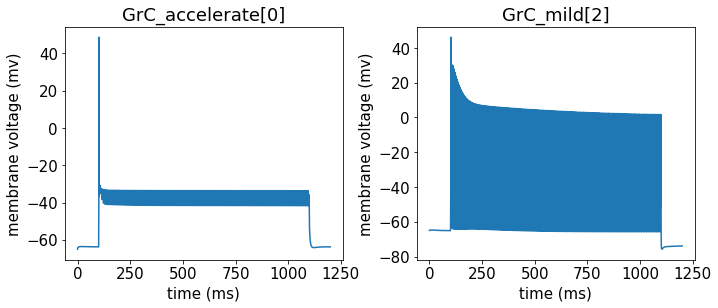

<Figure size 432x288 with 0 Axes>

In [10]:
# plot traces of grc cells
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 2, figsize = (10, 8))

for j, grc_cell in enumerate(grc_cells):
    plt.subplot(len(grc_cells), 2, j + 1)

    plt.plot(t, grc_cell.vm, label=str(grc_cell))
    plt.title(f"{grc_cell}")
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")

    data = np.array(grc_cell.vm)
    width = get_halfwidth(data, threshold=0, distance=0.001) # function for halfwidth
    print(width)

    grc_fr_array.append(len(grc_cell.spike_time_vec)) # store number of times fired
    max_grc_v_array.append(np.max(data))
    min_grc_v_array.append(np.min(data))
    grc_halfwidth_array.append(width)

plt.tight_layout()
plt.show()
plt.savefig('sm_network_grc_cells.svg', dpi = 300, facecolor='white', transparent=True)

[0.43047682 0.43215443 0.43206167 0.4275193  0.43521475 0.43779898
 0.43516364 0.43667816 0.42962253 0.43196478 0.43330845 0.43333049
 0.43338694 0.43369439 0.43349579 0.43511858 0.43299876 0.43289976
 0.4330398  0.43286838 0.4337642  0.432455   0.43269134 0.43323428
 0.43290499 0.43598669 0.43257798 0.43227747 0.43296464 0.43228859
 0.43484439 0.43247556 0.4360353  0.43292074 0.43653583 0.43376681
 0.4331571  0.43265273 0.43323412 0.43384197 0.43187276 0.4324097
 0.43354574 0.43407988 0.43098747 0.43237821 0.4317726  0.43177983
 0.43561336 0.43067264 0.43216144 0.43186307 0.43188348 0.43036221
 0.43398343 0.42983427 0.43328232 0.43519247 0.43200233 0.43333099
 0.43010957 0.43324044 0.43057457 0.43153386 0.4293677  0.43116401
 0.43364937]
[0.40554352 0.40914328 0.4020296  0.40547541 0.42269141 0.41569133
 0.41012215 0.41207813 0.40845404 0.41024826 0.4098131  0.41036661
 0.41657001 0.4112665  0.41260559 0.41272237 0.41002328 0.41107693
 0.41230712 0.41104934 0.41135287 0.41313484 0.410

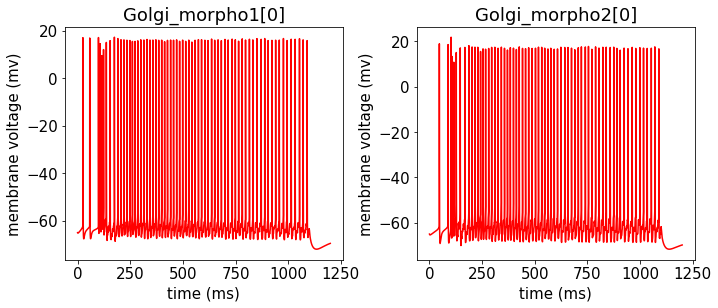

<Figure size 432x288 with 0 Axes>

In [11]:
# plot traces of golgi cells
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 2, figsize = (10, 8))

for j, golgi_cell in enumerate(golgi_cells):
    plt.subplot(len(golgi_cells), 2, j + 1)

    plt.plot(t, golgi_cell.vm, label=str(golgi_cell), color=('red'))
    plt.title(f"{golgi_cell}")
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")

    data = np.array(golgi_cell.vm)
    width = get_halfwidth(data, threshold=0, distance=0.001) # function for halfwidth
    print(width)

    golgi_fr_array.append(len(np.array(golgi_cell.spike_time_vec))) # store number of times fired
    max_golgi_v_array.append(np.max(data)) # store max amp
    min_golgi_v_array.append(np.min(data)) # store min amp
    golgi_halfwidth_array.append(width)

plt.tight_layout()
plt.show()
plt.savefig('sm_network_golgi_cells.svg', dpi = 300, facecolor='white', transparent=True)

In [12]:
sim_dict = {'data': {'time_array': t,
                     'stim_rec_array': stim_rec_array,
                    #  'stims_array': stims_array,
                     'golgi_input_resis_array': golgi_input_resis_array,
                     'grc_input_resis_array': golgi_input_resis_array,
                     'golgi_fr_array': golgi_fr_array,
                     'grc_fr_array': grc_fr_array,      
                    #  'golgi_ncs_array': golgi_ncs_array,
                    #  'grc_ncs_array': grc_ncs_array,
                     'golgi_halfwidth_array': golgi_halfwidth_array,
                     'grc_halfwidth_array': grc_halfwidth_array,
                     'max_golgi_v_array': max_golgi_v_array,
                     'min_golgi_v_array': min_golgi_v_array,
                     'max_grc_v_array': max_golgi_v_array,
                     'min_golgi_v_array': min_golgi_v_array},
            'metadata': {#'grc_cells': grc_cells, 
                         #'golgi_cells': golgi_cells, 
                         #'ascending_axons': ascending_axons,
                         #'parallel_fibers': parallel_fibers,
                         'amp': amp,
                         'freq': freq,
                         'start_time': start_time,
                         'stop_time': stop_time,
                         'spike_times': spike_times},
                        #  'synapse_data_pf': stim_data_pf,
                        #  'synapse_data_mf': stim_data_mf,
                        #  'synapse_data_aa': stim_data_aa},
            'parameters': {'time_steps': h.dt,
                           'temp': h.celsius,
                           'v_init': h.v_init,
                           'duration': h.tstop}}

In [13]:
# export data using hdf5 utils function to import into generate figures
file_path = 'data/sim_history.hdf5'
model_name = 'sm_network'
export_data(sim_dict, model_name, file_path) 

<HDF5 group "/sm_network" (0 members)>
<HDF5 dataset "time_array": shape (48001,), type "<f8">
<HDF5 dataset "stim_rec_array": shape (4, 48001), type "<f8">
<HDF5 dataset "golgi_input_resis_array": shape (0,), type "<f8">
<HDF5 dataset "grc_input_resis_array": shape (0,), type "<f8">
<HDF5 dataset "golgi_fr_array": shape (2,), type "<i8">
<HDF5 dataset "grc_fr_array": shape (2,), type "<i8">


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/h5py/_hl/base.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data, order="C", dtype=as_dtype)


TypeError: Object dtype dtype('O') has no native HDF5 equivalent